<p style="font-size: 45px;">
  Análisis y Predicción de Datos Meteorológicos con Métodos de Interpolación
</p>


Este notebook explora el análisis de datos meteorológicos, centrándose en las temperaturas diarias de una ciudad a lo largo de un año. Se utilizaran diferentes métodos de interpolación, incluyendo <b>interpolación de Taylor, interpolación de Lagrange, interpolación de Hermite e interpolación polinómica a trozos</b>. El objetivo es comparar la precisión y adecuación de cada método para modelar y predecir datos meteorológicos.

<h1><b>Interpolación de Taylor<b></h1>

Para la interpolación de Taylor se recolectó datos metereológicos de la ciudad de Valencia, Venezuela, en la fecha del 11/06/2024 al 16/06/24, los cuales fueron guardados en un archivo csv el cual para su lectura se realizó lo siguiente: 

In [2]:
using CSV
using SymPy

temperaturas = CSV.readlines("temperatus.csv")

7-element Vector{String}:
 "21,29"
 "21,29"
 "21,30"
 "21,30"
 "21,29"
 "20,28"
 "20,28"

Leído los datos de las temperaturas se procede a calcular la temperatura promedio de cada día y a graficar

Temperatura media del Lunes(1): 25.0 C°
Temperatura media del Martes(2): 25.0 C°
Temperatura media del Miércoles(3): 25.5 C°
Temperatura media del Jueves(4): 25.5 C°
Temperatura media del Viernes(5): 25.0 C°
Temperatura media del Sábado(6): 24.0 C°
Temperatura media del Domingo(7): 24.0 C°


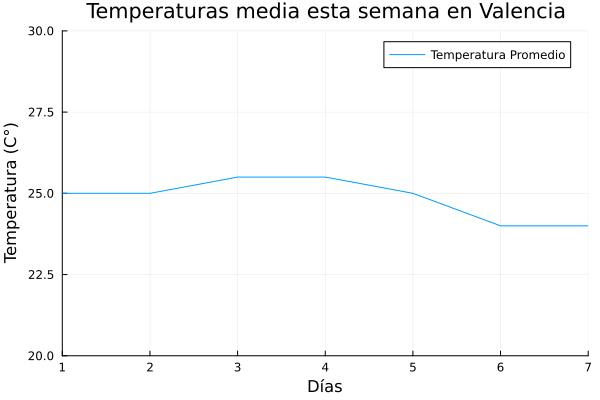

In [3]:
using Plots
#Listas para almacenar las temperaturas
temperaturas_min = []
temperaturas_max = []
temperaturas_prom = []

#Lista para los días de la semana
dias_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

#Lee el archivo y almacena los valores en las listas

for fila in temperaturas[1:end]
    columnas = split(fila, ",")
    max_temp = parse(Float64, columnas[1])
    min_temp = parse(Float64, columnas[2])
    numerador =  max_temp + min_temp
    denominador = length(columnas)

    push!(temperaturas_max, max_temp)
    push!(temperaturas_min, min_temp)

    promedio_temp = numerador / denominador
    push!(temperaturas_prom, promedio_temp)
end

#Imprime la temperatura media por día
for i in 1:length(temperaturas_prom)
    dia = dias_semana[(i - 1) % length(dias_semana) + 1]
    println("Temperatura media del ", dia, "(",i,"): ", temperaturas_prom[i], " C°")
end

dias = collect(1:length(temperaturas_prom))

#Grafica la temperatura media por día
plot(dias, temperaturas_prom, label="Temperatura Promedio", xlabel="Días", ylabel="Temperatura (C°)", title="Temperaturas media esta semana en Valencia")
ylims!(20,30)
xlims!(1,7)

Una vez calculada la temperatura promedio y graficada, se procede a calcular la interpolación de Taylor

La predicción sobre el punto es: 23.62°C


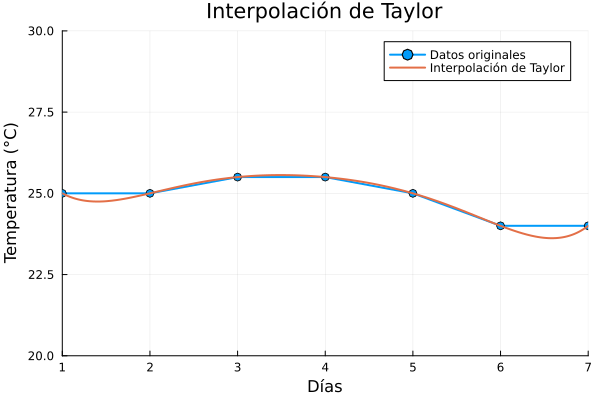

In [9]:
using SymPy

function InterpolacionTaylor(temperaturas_prom, dias, punto)
    x = symbols("x")
    n = length(dias)
    
    #Calcular diferencias finitas
    diferencias = [temperaturas_prom]
    for i in 1:(n-1)
        diff_temp = []
        for j in 1:(length(diferencias[end])-1)
            push!(diff_temp, diferencias[end][j+1] - diferencias[end][j])
        end
        push!(diferencias, diff_temp)
    end
    
    #Se construye Taylor
    s_Taylor = diferencias[1][1]
    factorial = 1
    for i in 1:(n-1)
        factorial *= i
        terminos = diferencias[i+1][1] / factorial
        for j in 0:(i-1)
            terminos *= (x - dias[j+1])
        end
        s_Taylor += terminos
    end
    
    #Predicción
    predict = subs(s_Taylor, x, punto)
    
    return s_Taylor, predict, punto
end

#Se calcula la interpolación de Taylor
punto = 6.6
taylor, predict, punto = InterpolacionTaylor(temperaturas_prom, dias, punto)

#Se imprime la predicción
predict_en_num = N(predict)
println("La predicción sobre el punto es: ", round(predict_en_num, digits=2), "°C")

#Se grafica la interpolación de Taylor y los datos originales
plot(dias, temperaturas_prom, label="Datos originales", lw=2, marker=:o)
plot!(taylor, 1, 7, label="Interpolación de Taylor", lw=2)
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación de Taylor")
ylims!(20, 30)
xlims!(1, 7)

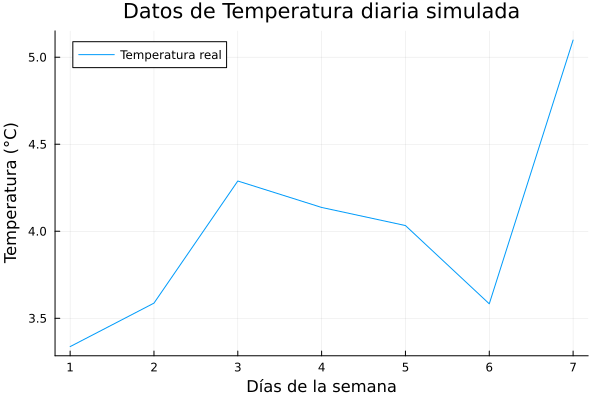

In [ ]:
using Plots

# Generación de datos simulados
n_dias = 7
dias = 1:n_dias
true_temps = 15 .+ 10 .* sin.(2 * pi * (dias .- 80) ./ 365) .+ randn(n_dias) # Temperaturas con variabilidad aleatoria

# Graficar los datos simulados
plot(dias, true_temps, label="Temperatura real", xlabel="Días de la semana", ylabel="Temperatura (°C)", title="Datos de Temperatura diaria simulada")

<h1><b>Interpolacion de Lagrange</b></h1>

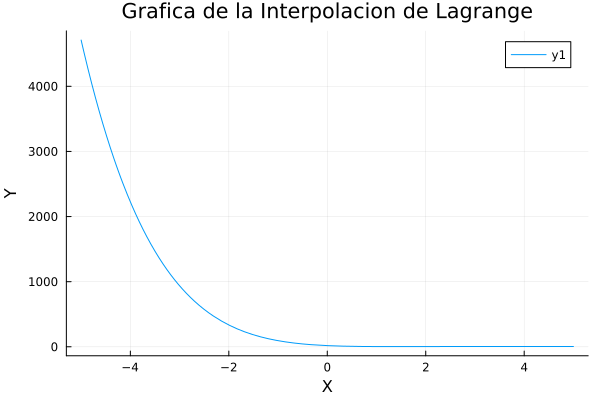

In [28]:
function InterpolacionGeneradorLagrange(xv,yv)
    function InterpolacionLagrange(x)
        numvalstoevaluate = length(x)
        numvalstoevaluate == 1 ? output = 0 : output = zeros(numvalstoevaluate)
        for k = 1:numvalstoevaluate
            N = length(xv)
            LagrangePolynomials = ones(N)
            for i in 1:N  
                for j in [1:i-1;i+1:N]    
                    LagrangePolynomials[i] = LagrangePolynomials[i].*(x[k]-xv[j])./(xv[i]-xv[j])
                end
            end
            numvalstoevaluate == 1 ? output = sum(LagrangePolynomials.*yv) : output[k] = sum(LagrangePolynomials.*yv)
        end
        return output
    end
    return InterpolacionLagrange
end

interpolacionfunc = InterpolacionGeneradorLagrange(dias,true_temps)
plot(interpolacionfunc, xlabel="X", ylabel="Y", title="Grafica de la Interpolacion de Lagrange")

<h1><b>Interpolación de Hermite</b></h1>

Valor interpolado en x = 6.6 es 23.29 C°


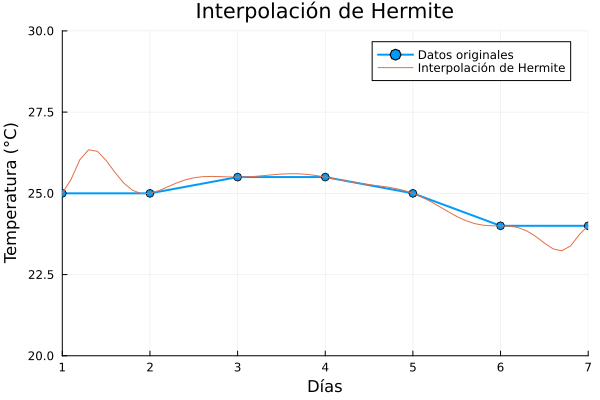

In [5]:
#Se calculan las derivadas
function calcular_derivadas(deriv, dias_h, temps)
    longitud = length(dias_h)
    for xi in 1:longitud-1
        dy = (temps[xi+1] - temps[xi]) / 1.0
        deriv[xi] = dy
    end
end

#Tabla para las diferencias divididas
function construir_tabla_diferencias(tabla, dias_h, temps, deriv)
    filas, columnas = size(tabla)
    cont = -1

    for col in 1:columnas
        idx = 1
        for fil in 1:filas
            if col == 1
                tabla[fil, col] = dias_h[idx]
                if iseven(fil) #iseven() verifica si es par el valor
                    idx += 1
                end

            elseif col == 2
                tabla[fil, col] = temps[idx]
                if iseven(fil)
                    idx += 1
                end

            elseif col == 3
                if fil <= (filas - cont)
                    if tabla[fil, 1] == tabla[fil + 1, 1]
                        tabla[fil, col] = deriv[Int(tabla[fil, 1])]
                    else
                        tabla[fil, col] = (tabla[fil + 1, col - 1] - tabla[fil, col - 1]) / (tabla[fil + 1, 1] - tabla[fil, 1])
                    end
                end

            else
                if fil <= (filas - cont)
                    tabla[fil, col] = (tabla[fil + 1, col - 1] - tabla[fil, col - 1]) / (tabla[fil + cont, 1] - tabla[fil, 1])
                end
            end
        end
        cont += 1
    end
end

#Se calcula el polinomio de Hermite
function calcular_polinomio_hermite(tabla, x)
    polinomio = 0.0
    fila_actual = 1
    
    for col in 2:size(tabla, 2)
        if col == 2
            polinomio += tabla[fila_actual, col]
        else
            termino = tabla[fila_actual, col]
            for k in 1:(col - 2)
                termino *= (x - tabla[k, 1])
            end
            polinomio += termino
        end
    end
    return polinomio
end

#Se pasan los valores a las funciones
derivadas = zeros(Float64,length(dias))
calcular_derivadas(derivadas, dias, temperaturas_prom)

filas = length(temperaturas_prom) + length(derivadas)
columnas = filas + 1 
tabla = zeros(Float64, filas, columnas)
construir_tabla_diferencias(tabla, dias, temperaturas_prom, derivadas)

@syms x
polinomio = calcular_polinomio_hermite(tabla, x) #Calcula el polinomio de Hermite

#Se imprime el valor interpolado
valor_interpolado = calcular_polinomio_hermite(tabla, punto)
println("Valor interpolado en x = ", punto," es ", round(valor_interpolado, digits=2), "°C")

# Graficar los datos originales y la interpolación de Hermite
rangox_h = minimum(1):0.1:maximum(7)
polinomio_h = zeros(Float64,length(rangox_h))

for i in 1:length(rangox_h)
    valores = calcular_polinomio_hermite(tabla, rangox_h[i])
    polinomio_h[i] = valores
end

plot(dias, temperaturas_prom, label="Datos originales", lw=2, marker=:o)
plot!(rangox_h, polinomio_h, label="Interpolación de Hermite")
xlabel!("Días")
ylabel!("Temperatura (°C)")
ylims!(20,30)
xlims!(1, 7)
title!("Interpolación de Hermite")